##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Post-Training Integer Static Quantization : MNIST

Ce notebook est un dérivé du notebook tutoriel créé directement par Tensor Flow. 
La source est disponible ci-dessous :

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_integer_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Synthèse

La quantification des nombres entiers est une stratégie d'optimisation qui convertit les nombres à virgule flottante de 32 bits (tels que les poids et les sorties d'activation) en nombres à virgule fixe de 8 bits les plus proches. Il en résulte un modèle plus petit et une vitesse d'inférence accrue, ce qui est précieux pour les dispositifs à faible consommation d'énergie tels que les [microcontrôleurs](https://www.tensorflow.org/lite/microcontrollers). Ce format de données est également requis par les accélérateurs à nombres entiers uniquement, tels que l'[Edge TPU](https://coral.ai/).


Dans ce tutoriel, vous allez entraîner un modèle MNIST à partir de zéro, le convertir en un fichier Tensorflow Lite, et le quantifier en utilisant [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). Enfin, vous vérifierez la précision du modèle converti et le comparerez au modèle flottant original.


Vous disposez en fait de plusieurs options pour quantifier un modèle. Dans ce tutoriel, vous effectuerez une "quantification intégrale", qui convertit tous les poids et toutes les sorties d'activation en données entières de 8 bits, alors que d'autres stratégies peuvent laisser une certaine quantité de données en virgule flottante.


Pour en savoir plus sur les différentes stratégies de quantification, lisez [TensorFlow Lite model optimization](https://www.tensorflow.org/lite/performance/model_optimization).

## Objectif

L'objectif de ce hands-on est de créer un modèle, de l'entrainer, de le quantifier, de comparer les performances entre le modèle classique et quantifié et de comparer leurs émissions CO2eq pour l'inférence.

Le déroulement se fait donc en 3 grandes étapes :
1. Contruction d'un modèle simple pour MNIST
2. Conversion et quantification du modèle
3. Comparaison des modèles TFLite

## Dataset

Le dataset utilisé pour ce notebook est le célèbre MNIST (Modified National Institute of Standards and Technology), composé d'images de chiffres manustricts, de taille 28x28. Le dataset contient 60000 imgaes d'entrainement et 10000 de test.

[Wikipédia MNIST](https://en.wikipedia.org/wiki/MNIST_database)

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png">

## Construction d'un modèle simple pour MNIST

### Préparation

In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib
print(tf.__version__)

2.12.0


### Entrainement du modèle

<a id='simple_cnn_model'></a>

Tout d'abord, on commence par créer une fonction _simple_cnn_model_ pour définir notre modèle séquentiel.
Le modèle est composé d'une seule couche de convolution et d'une couche MLP de sortie.

In [2]:
def simple_cnn_model():
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(28, 28)),
        keras.layers.Reshape(target_shape=(28, 28, 1)),
        keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(10)
    ])
    return model

Il nous faut après charger les données du dataset MNIST, directement avec Keras, que l'on va normaliser.

<div class="alert alert-block alert-info"><b>Note:</b> Plusieurs datasets sont directements accessibles avec le module <a href="https://www.tensorflow.org/api_docs/python/tf/keras/datasets">keras.datasets</a> (documentation Tensor Flow). <br>
&emsp;&emsp;&emsp; La liste est aussi disponible sur la <a href="https://keras.io/api/datasets/">documentation de l'API Keras.</a></div>

In [3]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

---
Enfin, il nous reste à définir le modèle avec la [fonction créée ci-dessus](#simple_cnn_model), puis de le compiler de façon classique et l'entrainer.

Nous commençons par 1 seule epoch.

In [4]:
# Define the model architecture
model = simple_cnn_model()

# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)

Metal device set to: Apple M1 Pro


2023-05-31 16:11:57.616881: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1875/1875 [==============================] - 10s 5ms/step - loss: 0.2836 - accuracy: 0.9204 - val_loss: 0.1301 - val_accuracy: 0.9620


Pour cet exemple, nous n'avons entraîné le modèle que sur une seule epoch, il n'atteint donc que __~96% de précision__.

En passant, voyons voir combien d'images sont présentes dans notre ensemble de test puisque nous allons utliser ces images pour comparer la performance des modèles.

In [5]:
len(test_images)

10000

## Conversion et quantification du modèle

### Conversition en modèle TensorFlow Lite

En utilisant le convertisseur de TensorFlow Lite, [Converter](https://www.tensorflow.org/lite/models/convert), il est facilement possible de convertir le modèle entraîné en modèle TensorFlow Lite.

Chargeons maintenant le modèle en utilisant `TFLiteConverter`:

In [6]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmperwuujb0/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmperwuujb0/assets
2023-05-31 16:12:11.455486: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-31 16:12:11.455501: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


Nous pouvons maintenant enregistrer ce modèle de base.

In [7]:
tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [8]:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84820

Nous avons donc une taille autours des 85000 bytes, soit environ 0.08 Mb (petite taille normale dûe à la simplicité du modèle).

### Quantification du modèle en Integer

Pour quantifier les données variables (telles que les entrées/sorties du modèle et les intermédiaires entre les couches), vous devez fournir un [`RepresentativeDataset`](https://www.tensorflow.org/api_docs/python/tf/lite/RepresentativeDataset). Il s'agit d'une fonction génératrice qui fournit un ensemble de données d'entrée suffisamment important pour représenter des valeurs typiques. Elle permet au convertisseur d'estimer une plage dynamique pour toutes les données variables. (Il n'est pas nécessaire que l'ensemble de données soit unique par rapport à l'ensemble de données d'apprentissage ou d'évaluation).

Pour prendre en charge des entrées multiples, chaque point de données représentatif est une liste et les éléments de la liste sont transmis au modèle en fonction de leurs indices.

In [9]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        # Model has only one input so each data point has one element.
        yield [tf.cast(input_value, tf.float32)]

Nous allons ensuite utiliser le flag par défault de `optimizations` pour quantifier l'intégralité des paramètres fixes (poids etc.). 
Puis nous allons donner le générateur de données représentatives aux convertisseur, avant d'enregistrer le modèle.

<div class="alert alert-block alert-warning">
        <b>Attention:</b> Si on ne fournit pas de dataset représentatif au convertisseur, <b>avec le flag par défaut d'optimisation</b>, la quantification appliquée serait une de la plage dynamique et non en entier statiques.
</div>

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_data_gen # For full integer static quantization
tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpbqrd4mpf/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpbqrd4mpf/assets
/Users/axel.de.labriffe/miniforge3/envs/tensorflow-v3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-05-31 16:12:18.191682: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-31 16:12:18.191696: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


Pour maintenir la compatibilité avec les applications qui utilisent traditionnellement des tenseurs d'entrée et de sortie de modèle en float, le convertisseur TensorFlow Lite laisse les tenseurs d'entrée et de sortie de modèle en float.

In [11]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


Pour quantifier les tenseurs d'entrée et de sortie et faire en sorte que le convertisseur envoie une erreur s'il rencontre une opération qu'il ne peut pas quantifier, convertissez à nouveau le modèle avec quelques paramètres supplémentaires.

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpha6340xn/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpha6340xn/assets
/Users/axel.de.labriffe/miniforge3/envs/tensorflow-v3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-05-31 16:12:21.618516: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-31 16:12:21.618529: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


La quantification interne reste la même que ci-dessus, mais vous pouvez voir que les tenseurs d'entrée et de sortie sont maintenant au format entier aussi.

In [13]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


Enfin, on peux enregistrer notre modèle quantifié.

In [14]:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24608

Notons que le fichier de sortie ne fait environ que `1/4` de la taille du modèle originel.

In [15]:
!ls -lh {tflite_models_dir}

total 224
-rw-r--r--  1 axel.de.labriffe  wheel    83K 31 mai 16:12 mnist_model.tflite
-rw-r--r--  1 axel.de.labriffe  wheel    24K 31 mai 16:12 mnist_model_quant.tflite


## Comparaison des modèles TFLite

Nous allons lancer les modèles TensorFlow Lite en utilisant l'interpreteur Python de TensorFlow Lite
`Interpreter`.

### Test du modèle sur une image

Nous allons maintenant exécuter des inférences en utilisant TensorFlow Lite [`Interpreter`] (https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) pour comparer la précision des modèles.


Tout d'abord, nous avons besoin d'une fonction qui exécute l'inférence avec un modèle et des images donnés (ici nos images de test), puis renvoie les prédictions.

In [16]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global test_images

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_images[test_image_index]
        test_label = test_labels[test_image_index]

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax()

    return predictions

Créons une autre fonction pour imprimer nos prédictions.

In [17]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
    global test_labels

    predictions = run_tflite_model(tflite_file, [test_image_index])

    plt.imshow(test_images[test_image_index])
    template = model_type + " Model \n True:{true}, Predicted:{predict}"
    _ = plt.title(template.format(true= str(test_labels[test_image_index]), 
                                  predict=str(predictions[0])))
    plt.grid(False)

Puis faisons un test pour le modèle Float :

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


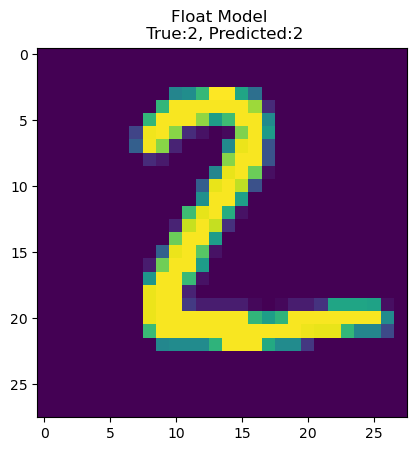

In [18]:
test_model(tflite_model_file, test_image_index, model_type="Float")

Puis pour le modèle Quantifé :

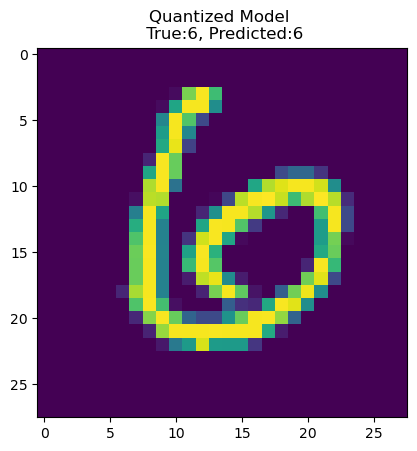

In [19]:
test_image_index = 11
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

### Evaluations des modèles

Nous allons maintenant comparer les performances du modèle flottant et du modèle quantifié :

+ `tflite_model_file` est le modèle TensorFlow Lite original avec des données en virgule flottante.

+ `tflite_model_quant_file` est le dernier modèle que nous avons converti en utilisant la quantification des entiers seulement (il utilise des données uint8 pour l'entrée et la sortie).

In [20]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
    global test_images
    global test_labels

    test_image_indices = range(test_images.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)

    accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

    print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

Nous allons donc tester ces modèles sur le dataset de test, plusieurs fois pour obtenir un temps moyen.

In [21]:
%%timeit -r 5 -n 1
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 96.2000% (Number of test samples=10000)
Float model accuracy is 96.2000% (Number of test samples=10000)
Float model accuracy is 96.2000% (Number of test samples=10000)
Float model accuracy is 96.2000% (Number of test samples=10000)
Float model accuracy is 96.2000% (Number of test samples=10000)
372 ms ± 11.3 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [22]:
%%timeit -r 5 -n 1
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 96.1900% (Number of test samples=10000)
Quantized model accuracy is 96.1900% (Number of test samples=10000)
Quantized model accuracy is 96.1900% (Number of test samples=10000)
Quantized model accuracy is 96.1900% (Number of test samples=10000)
Quantized model accuracy is 96.1900% (Number of test samples=10000)
354 ms ± 7.39 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


On constate ici que le gain en temps d'inférence est minime, probablement puisqu'il s'agit d'un très petit modèle.

### Evaluation Code Carbon

Nous allons maintenant faire une comparaison via la librairie Code Carbon qui permet d'estimer l'impact carbone d'un code en prenant en compte le CPU, la RAM etc.

Pour plus d'informations, visitez la [documentation officielle](https://mlco2.github.io/codecarbon/).

In [23]:
!pip install codecarbon

Nous allons utiliser _EmissionsTracker_ qui nous donnera des informations de consommations et les enregistrera aussi dans un fichier csv.

In [24]:
from codecarbon import EmissionsTracker

Puis comparons, pour une évaluation (donc 10000 inférences) la différence d'energie en kWh utilisé.
Commençons par le modèle classic Float.

In [25]:
with EmissionsTracker() as tracker:
    evaluate_model(tflite_model_file, model_type="Float")

[codecarbon INFO @ 16:13:02] [setup] RAM Tracking...
[codecarbon INFO @ 16:13:02] [setup] GPU Tracking...
[codecarbon INFO @ 16:13:02] No GPU found.
[codecarbon INFO @ 16:13:02] [setup] CPU Tracking...
[codecarbon WARNING @ 16:13:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:13:02] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 16:13:02] >>> Tracker's metadata:
[codecarbon INFO @ 16:13:02]   Platform system: macOS-13.4-arm64-arm-64bit
[codecarbon INFO @ 16:13:02]   Python version: 3.9.16
[codecarbon INFO @ 16:13:02]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 16:13:02]   Available RAM : 32.000 GB
[codecarbon INFO @ 16:13:02]   CPU count: 10
[codecarbon INFO @ 16:13:02]   CPU model: Apple M1 Pro
[codecarbon INFO @ 16:13:02]   GPU count: None
[codecarbon INFO @ 16:13:02]   GPU model: None
[codecarbon INFO @ 16:13:06] Energy consumed for RAM : 0.000001 kWh. RAM Power : 12.0 W
[codecarbon INFO @ 16:13:06] Energy consume

Float model accuracy is 96.2000% (Number of test samples=10000)


Puis le modèle Quantifié.

In [26]:
with EmissionsTracker() as tracker:
    evaluate_model(tflite_model_quant_file, model_type="Quantized")

[codecarbon INFO @ 16:13:06] [setup] RAM Tracking...
[codecarbon INFO @ 16:13:06] [setup] GPU Tracking...
[codecarbon INFO @ 16:13:06] No GPU found.
[codecarbon INFO @ 16:13:06] [setup] CPU Tracking...
[codecarbon WARNING @ 16:13:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:13:06] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 16:13:06] >>> Tracker's metadata:
[codecarbon INFO @ 16:13:06]   Platform system: macOS-13.4-arm64-arm-64bit
[codecarbon INFO @ 16:13:06]   Python version: 3.9.16
[codecarbon INFO @ 16:13:06]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 16:13:06]   Available RAM : 32.000 GB
[codecarbon INFO @ 16:13:06]   CPU count: 10
[codecarbon INFO @ 16:13:06]   CPU model: Apple M1 Pro
[codecarbon INFO @ 16:13:06]   GPU count: None
[codecarbon INFO @ 16:13:06]   GPU model: None
[codecarbon INFO @ 16:13:08] Energy consumed for RAM : 0.000001 kWh. RAM Power : 12.0 W
[codecarbon INFO @ 16:13:08] Energy consume

Quantized model accuracy is 96.1900% (Number of test samples=10000)


On voit ici que l'énergie annoncée est la même donc il n'y a pas de réduction étonamment.

## Synthèse

[TensorFlow Lite] (https://www.tensorflow.org/lite/) supporte
la conversion des poids en précision 8 bits dans le cadre de la conversion des modèles de
tensorflow graphdefs vers le format flat buffer de TensorFlow Lite. La quantification de la plage dynamique permet de réduire de 4 fois la taille du modèle. De plus, TFLite supporte la quantification et la déquantification à la volée des activations pour permettre de :

1.  Utiliser des noyaux quantifiés pour une mise en œuvre plus rapide lorsqu'ils sont disponibles.
2.  Mélanger des noyaux à virgule flottante avec des noyaux quantifiés pour différentes parties du graphe.
    du graphe.

Les activations sont toujours stockées en virgule flottante. Pour les opérations qui
supportent les noyaux quantifiés, les activations sont quantifiées à 8 bits de précision dynamiquement avant le traitement et sont déquantifiées à 8 bits de précision avant le traitement.
dynamiquement avant le traitement et sont déquantifiées en précision flottante après le
traitement.
__Selon le modèle converti, cela peut donner un gain de vitesse par rapport au calcul en virgule flottante par rapport au calcul en virgule flottante.__

Contrairement au QAT ([quantization aware training](https://github.com/tensorflow/tensorflow/tree/r1.14/tensorflow/contrib/quantize))
les poids sont quantifiés après l'apprentissage et __les activations sont quantifiées dynamiquement à l'inférence__. 
à l'inférence dans cette méthode.
Par conséquent, les poids du modèle ne sont pas ré-entraînés pour compenser les erreurs induites par la quantification.
de quantification. Il est important de vérifier la précision du modèle quantifié pour s'assurer que la dégradation est acceptable.
pour s'assurer que la dégradation est acceptable.

Ce tutoriel entraîne un modèle MNIST à partir de zéro, vérifie sa précision dans
TensorFlow, puis convertit le modèle en un flatbuffer Tensorflow Lite
avec quantification de la plage dynamique. Enfin, il vérifie la précision du modèle converti et la compare à celle de Tensorflow Lite.
l'exactitude du modèle converti et le compare au modèle flottant original.